In [90]:
%matplotlib inline
from __future__ import print_function
import argparse, gzip, cPickle, sys, time, itertools

import autograd.numpy as np
import autograd.numpy.random as npr
import autograd.scipy.stats.norm as norm
import autograd.scipy.stats.dirichlet as dirichlet
from autograd.scipy.misc import logsumexp
from autograd.util import flatten_func, flatten
from autograd import grad, primitive
from autograd.numpy.numpy_grads import unbroadcast

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn import mixture

from  autograd.scipy.special import gammaln, digamma, gamma
from scipy import linalg
from scipy import stats, integrate

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as animation
import pandas as pd
import six

color_names = ["maroon",               
               "gold",
               "royal blue"]
colors = sns.xkcd_palette(color_names)
sns.set_style("white")


class Adam(object):
    def __init__(self, dparam, learning_rate=0.001, b1=0.9, b2=0.999, eps=10**-8,
                         decay_rate = 0.9, decay_steps = 100):                    
        self.b1 = b1;
        self.b2 = b2;
        self.eps = eps
        self.learning_rate = learning_rate        
        self.m = np.zeros(dparam)
        self.v = np.zeros(dparam)
        self.i = 0
        self.decay_rate = decay_rate
        self.decay_steps = decay_steps
    
    def step(self, gradients):        
        self.i = self.i+1
        step_size = self.learning_rate * self.decay_rate**(self.i/self.decay_steps)
        self.m = (1 - self.b1) * gradients + self.b1 * self.m
        self.v = (1 - self.b2) * (gradients**2) + self.b2 * self.v
        mhat = self.m / (1 - self.b1**(self.i))
        vhat = self.v / (1 - self.b2**(self.i))        
        step = step_size*mhat/(np.sqrt(vhat) + self.eps)        
        return step

    
@primitive
def softplus(x):
    return np.log(1. + np.exp(x))

softplus.defvjp(lambda g, ans, vs, gvs, x: unbroadcast(vs, gvs, g * 1./(1. + np.exp(-x))))

def jacobian_softplus(x):
    return 1./(1. + np.exp(-x))

@primitive
def gamma_logpdf(x, alpha = 1., beta = 1.):
    return  (alpha*np.log(beta) + (alpha - 1)*np.log(x) - x*beta - gammaln(alpha))

gamma_logpdf.defvjp(lambda g, ans, vs, gvs, x, alpha=1.0, beta=1.0: unbroadcast(vs, gvs, g * ((alpha-1)/x - beta)))
gamma_logpdf.defvjp(lambda g, ans, vs, gvs, x, alpha=1.0, beta=1.0: unbroadcast(vs, gvs,  g * (np.log(beta) + np.log(x) - digamma(alpha))), argnum=1)
gamma_logpdf.defvjp(lambda g, ans, vs, gvs, x, alpha=1.0, beta=1.0: unbroadcast(vs, gvs,  g * (alpha/beta - x)), argnum=2)

In [35]:
class Normal(object):
    def __init__(self, data, scale = 1.):
        self.data = data     
        self.scale = scale
        self.N = data.shape[0]
        self.D = data.shape[1]
    
    def p_log_prob(self, idx, z):
        x = self.data[idx]
        mu, tau = z['mu'], softplus(z['tau'])
        log_prior = 0.
        log_prior = np.sum(gamma_logpdf(tau, 1e-3, 1e-3)) + np.sum(np.log(jacobian_softplus(z['tau'])))
        log_prior += np.sum(norm.logpdf(mu, 0., 1/np.sqrt(tau)))        
        log_lik = np.sum(norm.logpdf(x, mu, 1/np.sqrt(tau)))
        return self.scale * log_lik + log_prior
    
    def q_log_prob(self, params, z):
        q_mean = np.sum(norm.logpdf(z['mu'], params['mu']['mean'], np.exp(params['mu']['sigma'])))
        q_sigma = np.sum(norm.logpdf(z['tau'], params['tau']['mean'], np.exp(params['tau']['sigma'])))        
        return q_mean + q_sigma
      
    def q_log_prob_sep(self, params, z):
        q_mean = norm.logpdf(z['mu'], params['mu']['mean'], np.exp(params['mu']['sigma']))
        q_sigma = norm.logpdf(z['tau'], params['tau']['mean'], np.exp(params['tau']['sigma']))
        return np.concatenate([q_mean, q_sigma])
    
    def sample_q(self, params):
        sample = {}
        eps = {}        
        eps['mu'] = npr.randn(len(params['mu']['mean']))
        eps['tau'] = npr.randn(len(params['tau']['mean']))        
        q_mu_s = np.exp(params['mu']['sigma']) * eps['mu'] + params['mu']['mean'] 
        q_tau_s = np.exp(params['tau']['sigma']) * eps['tau'] + params['tau']['mean'] 
        sample['mu'] = q_mu_s        
        sample['tau'] = q_tau_s
        return (sample, eps)
        
    def grad_p(self, dp_log_prob, eps, params):        
        dp_log_prob_ = {'mu': {}, 'tau': {}}
        
        dp_log_prob_['mu']['mean'] = dp_log_prob['mu']
        dp_log_prob_['mu']['sigma'] = dp_log_prob['mu']*eps['mu']*np.exp(params['mu']['sigma']) + 1
        
        dp_log_prob_['tau']['mean'] = dp_log_prob['tau']
        dp_log_prob_['tau']['sigma'] = dp_log_prob['tau']*eps['tau']*np.exp(params['tau']['sigma']) + 1                
        return dp_log_prob_
        
    def calc_eps(self, z, params):        
        eps = {}                
        eps['mu']  = (z['mu'] - params['mu']['mean']) / np.exp(params['mu']['sigma'])  
        eps['tau']  = (z['tau'] - params['tau']['mean']) / np.exp(params['tau']['sigma'])          
        return eps            
    

In [77]:
class Inference(object):      
    def __init__(self, model, params):
        self.model = model
        self.params = params

    def run(self, epochs, batch_size, samples, learning_rate, algorithm = 'SGD', optimizer = 'adam'):
        self.epochs = epochs
        self.batches = self.model.N/batch_size
        self.batch_size = batch_size
        self.samples = samples
        self.learning_rate = learning_rate
        
        fparams, unflatten = flatten(self.params)
        self.D =len(fparams)

        self.loss = 0.
        self.F = np.zeros(self.epochs * self.batches)
        self.time = np.zeros(self.epochs * self.batches)
        self.n = 1
        adam = Adam(self.D, learning_rate = learning_rate)        
        f = 0
        
        grad_p_log_prob = grad(model.p_log_prob, argnum = 1)
        grad_q_log_prob = grad(model.q_log_prob, argnum = 1)
        p = []
        c = []
        
        if algorithm == 'SGD':
            for e in range(self.epochs):
                for b in range(self.batches): 
                    start = time.clock()
                    losses = 0.
                    d_elbo = 0.
                    idx = np.random.choice(np.arange(self.model.N), batch_size, replace=False)                                        

                    params = unflatten(fparams)                
                    for s in range(self.samples):
                        z, eps = model.sample_q(params)
                        p_log_prob = model.p_log_prob(idx, z)
                        g,_ =  flatten(model.grad_p(grad_p_log_prob(idx, z), eps, params))
                        d_elbo += g
                        q_log_prob = model.q_log_prob(params, z)                                         
                        losses +=  (p_log_prob - q_log_prob)
                    loss = losses/self.samples
                    d_elbo /= self.samples
                    step = adam.step(d_elbo)
                    fparams += step                        
                    self.F[f] =  -loss                
                    stop = time.clock()
                    p.append(unflatten(np.copy(fparams)))

                    self.time[f] = stop - start
                    f+=1
                if e % 10 == 0:
                    pstate = 'Epoch = ' + "{0:0=3d}".format(e) + ': Loss = {0:.3f}'.format(self.F[f-1])
                    print (pstate, end = '\r')
                    sys.stdout.flush()    
                    
        if algorithm == 'iSGD':
            n = 1.  
            z_old = [0.] * self.samples
            grad_p_old = [0.] * self.samples
            q_log_prob_old = [0.] * self.samples
            p_log_prob_old = [0.] * self.samples
            
            for e in range(self.epochs):
                for b in range(self.batches): 
                    start = time.clock()
                    losses = 0.
                    d_elbo = 0.
                    idx = np.random.choice(np.arange(self.model.N), batch_size, replace=False)                                        
                    params = unflatten(fparams)                
                    if n > .9:
                        for s in range(self.samples):
                            z, eps = model.sample_q(params)
                            p_log_prob = model.p_log_prob(idx, z)
                            q_log_prob = model.q_log_prob_sep(params, z)                                                                                          
                            grad_p = grad_p_log_prob(idx, z)
                            g,_ =  flatten(model.grad_p(grad_p, eps, params))
                            d_elbo += g                            
                            losses +=  (p_log_prob - np.sum(q_log_prob))
                            c.append("s")                            
                            z_old[s] = z
                            grad_p_old[s] = grad_p
                            q_log_prob_old[s] = q_log_prob
                            p_log_prob_old[s] = p_log_prob                    
                        loss = losses/self.samples
                        d_elbo /= self.samples
                    else:
                        for s in range(self.samples):
                            eps_ = model.calc_eps(z_old[s], params)
                            q_log_prob = model.q_log_prob_sep(params, z_old[s])                                      
                            w = np.exp(q_log_prob - q_log_prob_old[s]) 
                            gw, unflatten_gw = flatten(grad_p_old[s])
                            g,_ =  flatten(model.grad_p(unflatten_gw(w*gw), eps_, params))                                                        
                            d_elbo += g                            
                            c.append("i")                            

                        d_elbo /= self.samples
                    n = npr.uniform()
                    step = adam.step(d_elbo)
                    fparams += step                        
                    self.F[f] =  -loss                
                    stop = time.clock()
                    p.append(unflatten(np.copy(fparams)))

                    self.time[f] = stop - start
                    f+=1                       
                if e % 10 == 0:
                    pstate = 'Epoch = ' + "{0:0=3d}".format(e) + ': Loss = {0:.3f}'.format(self.F[f-1])
                    print (pstate, end = '\r')
                    sys.stdout.flush()       
                      
        if algorithm == 'iSAG':
            n = 1.  
            z_old = [[0.] * self.samples for b in range(self.batches)]            
            grad_p_old = [[0.] * self.samples for b in range(self.batches)]
            q_log_prob_old = [[0.] * self.samples for b in range(self.batches)]
            p_log_prob_old = [[0.] * self.samples for b in range(self.batches)]
            
            for e in range(self.epochs):
                for b in range(self.batches): 
                    start = time.clock()
                    losses = 0.
                    d_elbo = 0.                    
                    idx = np.random.choice(np.arange(self.model.N), batch_size, replace=False)                    
                    params = unflatten(fparams)                
                    for s in range(self.samples):
                        z, eps = model.sample_q(params)
                        p_log_prob = model.p_log_prob(idx, z)
                        q_log_prob = model.q_log_prob_sep(params, z)                                                                                          
                        grad_p = grad_p_log_prob(idx, z)
                        g,_ =  flatten(model.grad_p(grad_p, eps, params))
                        d_elbo += g                            
                        losses +=  (p_log_prob - np.sum(q_log_prob))
                        c.append("s")   

                        z_old[b][s] = z
                        grad_p_old[b][s] = grad_p
                        q_log_prob_old[b][s] = q_log_prob
                        p_log_prob_old[b][s] = p_log_prob                          
                    loss = losses/self.samples
                    d_elbo /= self.samples
                    if e > 0 and b == (self.batches - 1):
                        for t in range(self.batches):
                            for s in range(self.samples):
                                eps_ = model.calc_eps(z_old[t][s], params)
                                #q_log_prob = model.q_log_prob_sep(params, z_old[t][s])                                      
                                w = np.exp(q_log_prob - q_log_prob_old[t][s]) 
                                print(np.mean(w))
#                             
#                     else:
#                         for s in range(self.samples):
#                             eps_ = model.calc_eps(z_old[s], params)
#                             q_log_prob = model.q_log_prob_sep(params, z_old[s])                                      
#                             w = np.exp(q_log_prob - q_log_prob_old[s]) 
#                             gw, unflatten_gw = flatten(grad_p_old[s])
#                             g,_ =  flatten(model.grad_p(unflatten_gw(w*gw), eps_, params))                                                        
#                             d_elbo += g                            
#                             c.append("i")                            
#                         d_elbo /= self.samples
#                     n = npr.uniform()
                    step = adam.step(d_elbo)
                    fparams += step                        
                    self.F[f] =  -loss                
                    stop = time.clock()
                    p.append(unflatten(np.copy(fparams)))

                    self.time[f] = stop - start
                    f+=1                       
#                 print(" ")      
#                 params = unflatten(fparams)                
#                 for t in range(self.batches):
#                     for s in range(self.samples):
#                         eps_ = model.calc_eps(z_old[t][s], params) 
#                         q_log_prob = model.q_log_prob_sep(params, z_old[self.batches-1][s])                                      
#                         w = np.exp(q_log_prob - q_log_prob_old[t][s]) 
#                         print(np.mean(w))
                if e % 10 == 0:
                    pstate = 'Epoch = ' + "{0:0=3d}".format(e) + ': Loss = {0:.3f}'.format(self.F[f-1])
                    print (pstate, end = '\r')
                    sys.stdout.flush()    
        self.params = unflatten(fparams)   
        return (p,c)

0.942796017502oss = 15351.385
1.08657053787
2.22299792424
0.889845254281
1.00241650809
1.02589412027
0.989372958543
0.994171240636
0.757684767927
1.0
1.38617524122
1.16639911518
1.68410295937
1.58688234134
2.12465122377
1.4989929878
1.22559862415
1.38464330256
1.08562563687
1.0


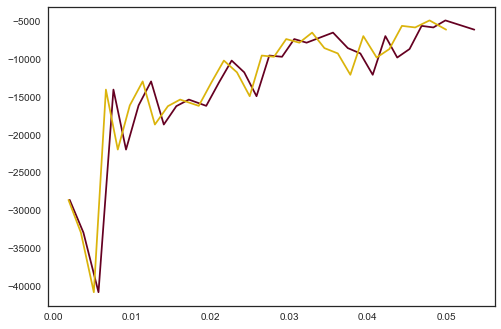

In [89]:
N = 1000
D = 1
batch_size = 100
epochs = 3
samples = 1
learning_rate = 0.1
seed = 111
npr.seed(seed)    
data = 5 * npr.randn(N*D).reshape([N,D])
    
N = data.shape[0]
D = data.shape[1]
model = Normal(data, N/batch_size)


npr.seed(seed)    
params = {}
params['mu'] = {'mean': npr.randn(D), 'sigma': npr.randn(D)}
params['tau'] = {'mean': npr.randn(D), 'sigma': npr.randn(D)}
inference = Inference(model, params)
inference.run(epochs, batch_size, samples, learning_rate, 'iSAG')
plt.plot(np.cumsum(inference.time), -inference.F, color = colors[0])

# npr.seed(seed)    
# params = {}
# params['mu'] = {'mean': npr.randn(D), 'sigma': npr.randn(D)}
# params['tau'] = {'mean': npr.randn(D), 'sigma': npr.randn(D)}
# inference = Inference(model, params)
# inference.run(epochs, batch_size, samples, learning_rate, 'iSGD')
# plt.plot(np.cumsum(inference.time), -inference.F, color = colors[0])

npr.seed(seed)    
params = {}
params['mu'] = {'mean': npr.randn(D), 'sigma': npr.randn(D)}
params['tau'] = {'mean': npr.randn(D), 'sigma': npr.randn(D)}
inference = Inference(model, params)
inference.run(epochs, batch_size, samples, learning_rate, 'SGD')
plt.plot(np.cumsum(inference.time), -inference.F, color = colors[1])

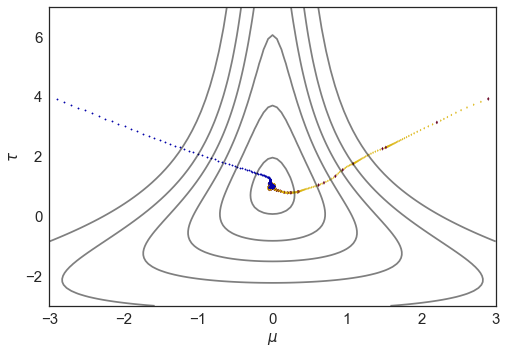

In [21]:

def log_density(x):
    mu, sigma = x[0], softplus(x[1])
    sigma_density = gamma_logpdf(sigma, 1e-3, 1e-3) + np.log(jacobian_softplus(x[1]))
    mu_density = norm.logpdf(mu, 0, 1/np.sqrt(sigma))
    return sigma_density + mu_density

sns.set_style(style='white')
x = np.linspace(-3, 3, 101)
y = np.linspace(-3, 7, 101)
X, Y = np.meshgrid(x, y)
zs = np.array([np.exp(log_density(theta))
               for theta in zip(np.ravel(X), np.ravel(Y))])        
Z = zs.reshape(X.shape)
#f, (ax1, ax2) = plt.subplots(2,1,figsize=(30,50))
plt.contour(X, Y, Z, colors = 'k', alpha = .5)

N = 1000
D = 1
batch_size = 1000
epochs = 500
samples = 1
learning_rate = 0.1
seed = 111
npr.seed(seed)    
data =  npr.randn(N*D).reshape([N,D])
    
N = data.shape[0]
D = data.shape[1]
model = Normal(data)

npr.seed(seed)    
params = {}
params['mu'] = {'mean': 3 * np.ones(D), 'sigma': npr.randn(D)}
params['tau'] = {'mean': 4 * np.ones(D), 'sigma': npr.randn(D)}
inference = Inference(model, params)
p,c = inference.run(epochs, batch_size, samples, learning_rate, 'iSGD')

col = {'s': colors[0], 'i': colors[1]}
area = {'s': 5, 'i': 2}
shape = {'s': 'd', 'i': '.'}
plt.scatter([t['mu']['mean'] for t in p], softplus([t['tau']['mean'] for t in p]), 
              s = [area[t] for t in c], alpha=1, color = [col[t]for t in  c],
           marker = 'd')             


npr.seed(seed)    
params = {}
params['mu'] = {'mean': -3 * np.ones(D), 'sigma': npr.randn(D)}
params['tau'] = {'mean': 4*np.ones(D), 'sigma': npr.randn(D)}
inference = Inference(model, params)
p,c = inference.run(epochs, batch_size, samples, learning_rate, 'SGD')
plt.scatter([t['mu']['mean'] for t in p], softplus([t['tau']['mean'] for t in p]), 
              s = 2, alpha=1, color = colors[2])     


plt.ylabel(r'$\tau$', fontsize = 15)
plt.xlabel(r'$\mu$', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.savefig('/home/sakaya/MUPI/papers/uai17importance/normal-illustration.png', dpi=300, bbox_inches= 'tight')
